<a href="https://colab.research.google.com/github/kunalkishanmehta/ns-struc-dm/blob/master/Two_fluid_code_clean_mpa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np # import packages
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [ ]:
# download and install the code

%%bash
# make this cell an instance of a terminal

git clone https://github.com/kunalkishanmehta/ns-struc-dm.git # download code repository from https://github.com/landryp/ns-struc/tree/enthalpy
python2 -m pip install scipy

mkdir /opt/bin /opt/lib/ /opt/lib/python2.7 /opt/lib/python2.7/site-packages # create install directory and make it findable
export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

cd /content/ns-struc-dm # install code
python2 setup.py install --prefix /opt/

echo -e '\n *** \n'

getnsprops -h # this is the executable from ns-struc that solves the TOV equations to compute neutron star observables; print its help string to see the syntax for calling it

echo -e '\n *** \n'

In [ ]:
%%bash
export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

cd /content/ns-struc-dm # install code
git pull
python2 setup.py install --prefix /opt/



In [ ]:
# calculate neutron star observables for a given equation of state

%%bash
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -r 0.,12. -n 48 -R 0.,12. # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Process is interrupted.


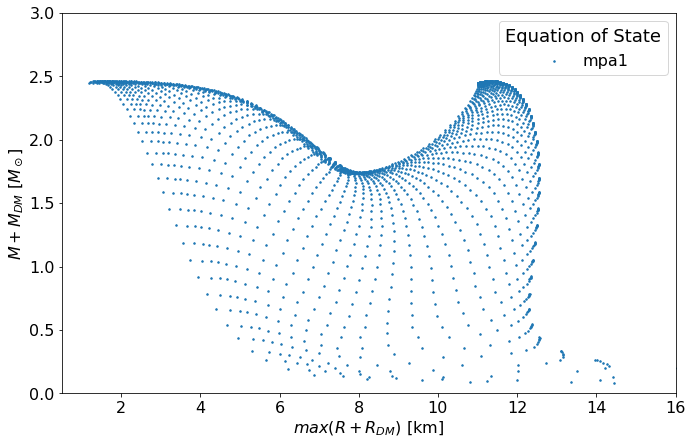

In [ ]:
# load the table of neutron star observablesthat was created above
mrl_data_mpa1 = np.genfromtxt('/content/macro-mpa1.csv',delimiter=',',names=True,dtype=None)


plt.figure(figsize= (11,7))

plt.scatter(mrl_data_mpa1['R'],(mrl_data_mpa1['Mg']), label = 'mpa1', marker = 'p', s =3)


plt.xlim(0.5,16.)
plt.ylim(0.,3.)
plt.xlabel(r'$max(R+R_{DM})$ [km]', size = 16) # add plot labels, etc.
plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
plt.legend(fontsize = 16, title='Equation of State',title_fontsize=18 , loc = 'upper right')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [ ]:
def filter_R(data,model,n):

  lim = np.argmax((data['M']+data['Mdm']))
  # plt.scatter(np.maximum(data['R'][:lim+10],data[:lim+10]['Rdm']),((data['M']+data['Mdm'])[:lim+10]), label = '{}'.format(model), marker = 'p')
  
  for i in range(len(data)):
    if data['R'][i] < data['Rdm'][i]:
      plt.scatter(data['R'][i],(data['M']+data['Mdm'])[i], marker = '.', color = 'lawngreen', s =3)
    elif data['R'][i] > data['Rdm'][i]:
      plt.scatter(data['R'][i],(data['M']+data['Mdm'])[i], marker = '.', color = 'm', s=3)
    else:
      plt.scatter(data['R'][i],(data['M']+data['Mdm'])[i], marker = 'o', color = 'b', s=3)

  # plt.plot(data['R'][0::n],(data['M']+data['Mdm'])[0::n], label = '{} R0'.format(model), color = 'k')
  plt.scatter(data['R'][0::n],(data['M']+data['Mdm'])[0::n], label = '{} R0'.format(model), color = 'k', s = 10)

  return

In [ ]:
def filter_fdm(data,model,n):

  # lim = np.argmax((data['M']+data['Mdm']))
  # plt.scatter(np.maximum(data['R'][:lim+10],data[:lim+10]['Rdm']),((data['M']+data['Mdm'])[:lim+10]), label = '{}'.format(model), marker = 'p')
  
  for i in range(len(data)):
    if data['fdm'][i] < 0.5:
      plt.scatter(data['R'][i],(data['Mg'])[i], marker = '.', color = 'm', s = 3)
    elif data['fdm'][i] > 0.5:
      plt.scatter(data['R'][i],(data['Mg'])[i], marker = '.', color = 'c', s = 3)
    else:
      plt.scatter(data['R'][i],(data['Mg'])[i], marker = '.', color = 'gray', s = 3)

  plt.scatter(data['R'][0::n],(data['Mg'])[0::n], label = '{} R0'.format(model), marker = 'o', color = 'k', s = 10)

  return

In [ ]:
def plots(data,i,n,R,model):
  
  plt.scatter(data['R'][i::n],(data['Mg'][i::n]), label = '{} R={}'.format(model,R))


  plt.xlim(8.,16.)
  plt.ylim(1.,3.)
  plt.xlabel(r'$max(R+R_{DM})$ [km]', size = 16) # add plot labels, etc.
  plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
  plt.legend(fontsize = 16, title='Equation of State',title_fontsize=18 )
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  return

In [ ]:
# load central density, radius and mass data (computed separately)

dat = np.genfromtxt('macro-mpa1.csv',delimiter=',',dtype=None,names=True)

In [ ]:
# to associate the dark matter fraction to each point in rhoc-rhocdm space, interpolate 3D (rhoc,rhocdm,fdm) data to get a function fdm(rhoc,rhocdm)

x = dat['rhoc'] # input data
y = dat['rhocdm']
z = dat['fdm']

X = np.linspace(0.1e14,3.1e15,1000) # the grid where we'll evaluate fdm(rhoc,rhocdm)
Y = np.linspace(0.1e14,3.1e15,1000)
x_grid, y_grid = np.meshgrid(X, Y)

outdat = scipy.interpolate.griddata((x,y),z,(x_grid,y_grid),'linear')
 # fdm evaluated on the grid, with one of three methods: nearest, linear, cubic

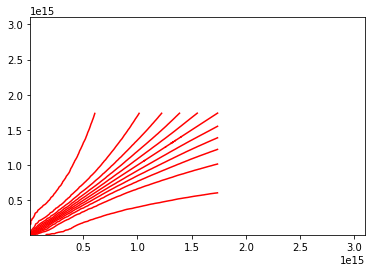

In [ ]:
# plot the interpolated fdm function 


num_cs = 9
cs = plt.contour(x_grid,y_grid,outdat,list(np.geomspace(1e-2,0.1,2))+list(np.linspace(0.1,0.9,num_cs)[1:])+list(reversed(1.-np.geomspace(1e-2,0.1,2)[:-1])),colors='r') # plot the contours of constant fdm(rhoc,rhocdm)



In [ ]:
# extract the (rhoc,rhocdm) coordinates of the constant-fdm contours

contours = []
for i in range(num_cs+3):
  try: c = cs.allsegs[i][0] # if a contour was plotted, save it
  except: continue
  contours += [c] # list that stores all the extracted contours




In [ ]:
# downsample the contours to get a list of (rhoc,rhocdm) coordinates to use to generate a constant-fdm sequence of stars

num_stars = 100 # how many stars to aim for in the sequence
rhocs, rhocdms = [], []

for c in contours:
  
  skip = int(len(c[:,0])/num_stars)
  rhocs += [c[::skip,0]]
  rhocdms += [c[::skip,1]] # downselect to num_stars (rhoc,rhocdm) points


rhomin = 2.8e14 # because some central densities are too small to give physical neutron stars, throw out those below rhomin
rhomax = 12*rhomin # because some central densities are too large to give physical neutron stars, throw out those above rhomax
rhocs_out, rhocdms_out = [], []

for c,cdm in zip(rhocs,rhocdms):
  c_out, cdm_out = [], []

  for rhoc,rhocdm in zip(c,cdm):
    
    if (rhoc >= rhomin or rhocdm >= rhomin) and rhoc <= rhomax and rhocdm <=rhomax: # one of rhoc/rhocdm below rhomin is ok, to allow pure regular matter or pure dm star
      c_out += [rhoc]
      cdm_out += [rhocdm]
  rhocs_out += [c_out]
  rhocdms_out += [cdm_out]

In [ ]:
def find_rhos(n):
  newrhoc = [str(r) for r in rhocs_out[n]]
  find_rhos.newrhocs_list = ','.join(newrhoc)

  newrhocdm = [str(r) for r in rhocdms_out[n]]
  find_rhos.newrhocdms_list = ','.join(newrhocdm)
  return find_rhos.newrhocs_list, find_rhos.newrhocdms_list


In [ ]:
find_rhos(0)

('285285285285285.3,302655695937194.44,319309309309309.3,329055548846172.5,344054054054054.06,359519519519519.56,371891891891892.0,387357357357357.4,396636636636636.7,408723289136410.2,420360710078107.0,432225554400299.94,444286924810972.0,458333450522018.5,470870870870870.9,483890058419966.7,498708708708708.75,511081081081081.1,526546546546546.6,542012012012012.0,554384384384384.44,566756756756756.8,582222222222222.2,597687687687687.8,610087604083143.6,625525525525525.5,640990990990991.0,656456456456456.5,668828828828828.9,684294294294294.4,698153395231166.0,712132132132132.1,727597597597597.6,743063063063063.1,758528528528528.6,773993993993994.0,789459459459459.5,804924924924925.0,820390390390390.4,835855855855855.9,851321321321321.4,866786786786786.9,879538141698524.0,894624624624624.6,912466113255510.8,928648648648648.8,947207207207207.2,962672672672672.8,978138138138138.2,993603603603603.8,1010979514965471.0,1027627627627627.8,1043093093093093.2,1058558558558558.8,1074529824272510

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour0 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.85285285285e+14 g/cm^3
Done at central density 1.7406521313e+15 g/cm^3
Save to /content/macro_contour0mpa1.csv


In [ ]:
find_rhos(1)

('280470868518023.44,294564564564564.56,306936936936936.94,320755804525723.75,334774774774774.8,347729576763518.2,365705705705705.75,378078078078078.1,390450450450450.5,405066619707588.3,417181645739943.5,430660660660660.7,445693627993252.2,461591591591591.6,475703255537045.1,489028415928064.6,504894894894894.9,517267267267267.3,532732732732732.75,545105105105105.1,560570570570570.6,579129129129129.1,591501501501501.5,606966966966967.0,622432432432432.5,634804804804804.9,650270270270270.2,665649783637261.8,678221538595255.6,693573573573573.6,709039039039039.1,724504504504504.5,737763613939252.8,753596730929140.8,767807807807807.9,783273273273273.4,797933050127054.4,811779901382487.9,828551534111682.4,845135135135135.2,858173491871934.6,872972972972973.0,888438438438438.5,903903903903904.0,919369369369369.5,934834834834834.9,950300300300300.4,966135258625171.2,984324324324324.4,999311725863324.4,1015255255255255.4,1030720720720720.8,1046186186186186.2,1061651651651651.8,1077255573812234

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour1 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.80470868518e+14 g/cm^3
Done at central density 1.73594594595e+15 g/cm^3
Save to /content/macro_contour1mpa1.csv


In [ ]:
find_rhos(2)

('282192192192192.25,294564564564564.56,309554397440331.94,323815576570653.8,339133711633813.7,356426426426426.44,370386872772585.25,384264264264264.3,399729729729729.75,415195195195195.2,430660660660660.75,445596514545557.0,461480272251542.6,473963963963964.0,492522522522522.6,507987987987988.0,523453453453453.5,540434831797210.0,554384384384384.44,569849849849850.0,585953273620884.8,600780780780780.9,616398324353221.5,631711711711711.8,648014634788887.8,662642642642642.6,678108108108108.1,693810895675266.6,709039039039039.1,724504504504504.5,739969969969970.0,755435435435435.5,772734961876133.8,787611067079091.8,803945634156422.8,820390390390390.4,836543003522957.1,851459214900233.9,868039450421748.5,884964608171247.5,900810810810810.9,916334121535620.4,934834834834834.9,950300300300300.4,965765765765765.9,984324324324324.2,999789789789790.0,1015255255255255.2,1033813813813813.9,1049279279279279.4,1066962610878232.1,1083303303303303.5,1098768768768768.9,1117327327327327.5,11327927927

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour2 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.82192192192e+14 g/cm^3
Done at central density 1.74183267669e+15 g/cm^3
Save to /content/macro_contour2mpa1.csv


In [ ]:
find_rhos(3)

('287194199718210.4,303843843843843.9,319309309309309.3,334774774774774.8,350290805114090.25,368798798798798.8,384446476472267.0,400282731556850.75,415195195195195.2,431939071381488.25,449219219219219.25,466945767012268.56,483243243243243.25,498708708708708.75,516233442940947.4,532732732732732.75,549524601957639.1,566756756756756.8,582222222222222.2,599364147405167.5,616246246246246.2,631711711711711.8,649577755125536.1,665735735735735.8,681201201201201.2,698126315882507.2,715225225225225.2,730690690690690.8,748617323831682.5,764714714714714.8,782777684339897.8,798738738738738.8,815661926605296.1,832762762762762.8,851321321321321.2,867947491438143.5,885345345345345.2,901834227060755.5,919369369369369.5,936348351044103.9,953393393393393.5,971018616496989.2,987417417417417.5,1005668393970017.9,1022176930184015.2,1040000000000000.0,1058558558558558.5,1075312178990387.8,1092582582582582.6,1111141141141141.2,1128941397096304.2,1145165165165165.2,1163723723723723.8,1181484173027610.8,1197747

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour3 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.87194199718e+14 g/cm^3
Done at central density 1.73903903904e+15 g/cm^3
Save to /content/macro_contour3mpa1.csv


In [ ]:
find_rhos(4)

('288378378378378.4,303843843843843.9,319309309309309.3,334774774774774.8,351216792008755.25,368798798798798.8,384264264264264.3,396636636636636.7,413611164123059.9,430660660660660.7,447032416641360.2,463390555027559.0,477177216506027.1,495615615615615.6,511081081081081.1,526907703637762.4,542200972482269.3,557585296813239.56,575749632064792.2,591501501501501.5,606966966966967.0,622432432432432.5,637897897897897.9,654066017683777.9,670586487570049.2,687387387387387.4,702852852852852.9,718318318318318.4,734411795169231.8,751606010098365.0,767807807807807.8,783273273273273.4,800238631942799.8,815956078326405.6,832762762762762.8,848228228228228.2,865317997963767.8,882252252252252.2,897717717717717.8,913183183183183.2,929726466727361.8,947207207207207.2,962672672672672.8,979054309915093.8,996386642107364.9,1012162162162162.2,1028164309747294.8,1046186186186186.2,1061651651651651.8,1077588577114015.8,1095500700174871.0,1111141141141141.2,1127430453395238.5,1144990600621713.5,116063063063063

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour4 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.88378378378e+14 g/cm^3
Done at central density 1.72975975976e+15 g/cm^3
Save to /content/macro_contour4mpa1.csv


In [ ]:
find_rhos(5)

('282192192192192.25,300750750750750.75,313123123123123.1,325495495495495.5,340960960960961.0,365705705705705.75,390450450450450.5,412102102102102.1,436846846846846.9,458498498498498.5,483243243243243.25,495615615615615.6,507987987987988.0,520360360360360.4,545105105105105.1,569849849849849.9,594594594594594.6,606966966966967.1,619339339339339.4,631711711711711.8,644084084084084.1,656456456456456.4,668828828770104.1,681201199324421.0,693573571819851.6,705945945933859.1,718318317931449.8,730690690328235.9,743063063063063.1,755435435435435.5,767807807807807.9,780180180180180.2,804924924924925.0,829669669669669.8,854414414414414.5,866786786786786.8,879159159159159.1,891531531531531.5,903903903903904.0,916276276276276.4,928648648647503.8,941021020973977.1,953393393348616.9,965765765759519.9,978138137848811.5,990510510234403.6,1002882882882882.9,1018348348348348.4,1043093093093093.1,1064744744744744.8,1080210210301253.0,1092582583010688.1,1104954955201418.1,1123513513513513.6,11482582582582

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour5 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.82192192192e+14 g/cm^3
Done at central density 1.73594594595e+15 g/cm^3
Save to /content/macro_contour5mpa1.csv


In [ ]:
find_rhos(6)

('265060115152773.72,279419006037531.94,297055578937553.6,312524992608548.4,325495495495495.5,340747648060870.4,356039234944540.25,372117655432484.4,387357357357357.4,400184891314284.94,415195195195195.2,430660660660660.7,446126126126126.1,461486577764451.5,474595733294408.06,489429429429429.44,504894894894894.94,520360360360360.4,535825825825825.9,550555815144168.75,565070205951711.0,580078223765311.4,594787315203450.2,610060060060060.1,625525525525525.5,640771460683260.9,655070008017698.1,669019245007633.4,684294294294294.4,699759759759759.8,714356789048260.2,727871426330925.6,743063063063063.1,758528528528528.8,773227899024216.5,786603879662235.1,801831831831831.9,816998640266849.5,831725397418414.5,845595937442040.0,860600600600600.6,875336799292017.6,889217737396074.0,903903903903904.0,919369369369369.4,933223427706943.1,947207207207207.2,962505937183386.6,976248824617483.5,990510510510510.6,1005975975975976.0,1019790010347500.6,1033813813813813.9,1049279279279279.4,10630770697106

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour6 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.65060115153e+14 g/cm^3
Done at central density 1.54455292944e+15 g/cm^3
Save to /content/macro_contour6mpa1.csv


In [ ]:
find_rhos(7)

('241981981981982.0,255798393354921.47,269819819819819.88,287810415739169.1,300750750750750.75,314650598661523.9,328588588588588.6,344054054054054.06,359670906452260.56,374984984984985.0,387745324994644.06,402126865503805.06,417824077612900.25,430660660660660.7,446126126126126.1,458498498498498.5,473963963963964.0,488422038114490.5,502352337541793.06,517267267267267.3,532358703375274.44,545595019536285.25,560570570570570.6,575447219524824.8,588408408408408.5,603873873873874.0,618573516036139.1,631740124448015.2,647177177177177.2,660123465179589.5,675015015015015.0,688614456180306.6,702852852852852.9,715225225225225.2,729703596286170.9,743063063063063.1,757776382670604.2,770953146773609.1,785114251849962.8,798738738738738.8,812066286133573.8,826576576576576.6,839873497695844.0,854414414414414.5,866786786786786.9,880136130708933.0,893601654514228.0,906996996996997.0,919843429022977.8,934737777077928.8,947207207207207.2,960354479427185.9,973818348784957.2,987417417417417.5,100015842396025

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour7 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.41981981982e+14 g/cm^3
Done at central density 1.38886599907e+15 g/cm^3
Save to /content/macro_contour7mpa1.csv


In [ ]:
find_rhos(8)

('206049339533031.75,222156710974500.34,235795795795795.8,248168168168168.2,260540540540540.56,270509122544517.78,285285285285285.3,298450011196621.8,310030030030030.06,323416294676972.0,336725975291681.9,350240240240240.25,362612612612612.6,374984984984985.0,387357357357357.4,399729729729729.7,411079604621464.06,423992000321302.5,436846846846846.9,448965316108105.7,460064965559490.5,470870870870870.9,483243243243243.25,496632548281899.6,509803637594841.5,522316814361555.0,535067689868634.7,547205403132669.25,559261501822167.25,571621672100493.2,583973667305045.0,595446291693132.0,606966966966967.0,619078259637165.4,631711711711711.8,644084084084084.1,655089554035423.0,666032177191275.0,677870024518680.1,689779734709457.8,701010448149529.8,712132132132132.1,724504504504504.5,735503502520671.8,746506830441149.5,757517590992002.5,769506406415105.9,780416240096833.9,792552552552552.6,801831831831831.9,814204204204204.4,824829821097435.8,835855855855855.9,848228228228228.2,858078238747742.

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour8 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 2.06049339533e+14 g/cm^3
Done at central density 1.22558558559e+15 g/cm^3
Save to /content/macro_contour8mpa1.csv


In [ ]:
find_rhos(9)

('167747747747747.75,178851425959742.75,189399399399399.38,198678678678678.7,213687453831105.75,223423423423423.44,232236415735024.8,241981981981982.0,254354354354354.38,266726726726726.75,276767794484436.25,288378378378378.4,300750750750750.75,310930456759539.75,321661229309682.1,331023388684964.8,340455289115517.2,350789535456404.3,360998105918657.75,372764907895467.25,381826668452472.75,389980836021931.06,400971064680890.2,411764252759465.5,421381381381381.4,431467447082454.5,442957639527381.25,452312312312312.3,460672432965184.5,470870870870870.9,481267472100766.0,492449071381729.9,501801801801801.8,511081081081081.1,522366624846803.4,532053339850816.5,542012012012012.0,551291291291291.3,560570570570570.6,569235774011950.8,579129129129129.1,589068939253387.1,598490628514440.4,608595214004764.2,617312778804316.5,626098910569132.9,634804804804804.9,644084084084084.1,653363363363363.4,662642642642642.6,671341459073340.5,678675035462031.1,687717106187556.0,696666666666666.8,70594594594

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour9 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.67747747748e+14 g/cm^3
Done at central density 1.01511470622e+15 g/cm^3
Save to /content/macro_contour9mpa1.csv


In [ ]:
find_rhos(10)

('49135408832925.83,53303303303303.31,59189133838540.94,68768768768768.77,77162568371237.94,82159795608511.16,92466798503644.42,101588815002218.88,110785759364618.53,121351351351351.36,127537537537537.55,137721619665421.72,149189189189189.2,158468468468468.47,166199217095243.2,173933933933933.94,182984788564098.7,190237670833209.94,196890827679284.25,202943248136494.38,213559124874157.06,221250936887015.28,226903804150132.2,235242145319557.75,241981981981982.0,249163964889008.75,256519223566042.0,263633633633633.66,269948394575511.22,276006006006006.03,284405943472276.6,291997299283684.94,298848598269010.5,305078747638482.4,310030030030030.06,316216216216216.25,323398072419644.2,330365983900789.75,336830408806285.6,341739717394803.9,348558601431006.4,356369593290759.5,362612612612612.6,369181875842475.4,374984984984985.0,379505904332102.06,383858335750160.4,389787700103199.1,395491364655773.3,400927043194597.0,405915915915916.0,411364015247265.44,416702425775693.44,421381381381381.4,42

In [ ]:

# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour10 -r $1 -n 10 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 4.91354088329e+13 g/cm^3
Done at central density 6.06966966967e+14 g/cm^3
Save to /content/macro_contour10mpa1.csv


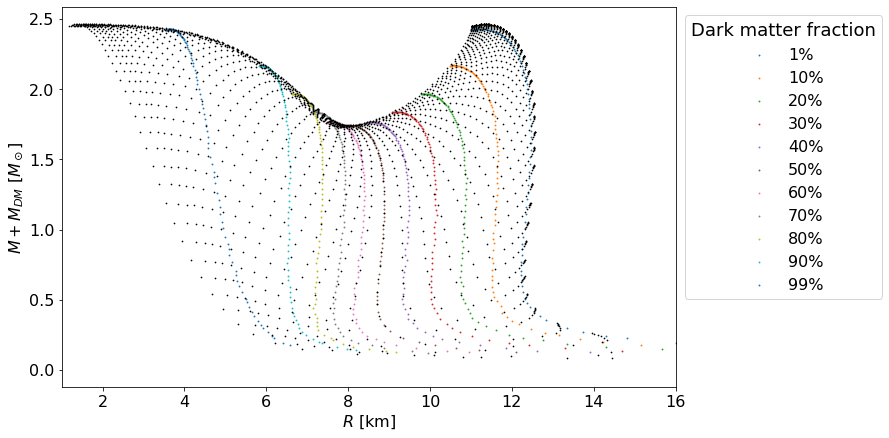

In [ ]:
data_con0 = np.genfromtxt('/content/macro_contour0mpa1.csv',delimiter=',',names=True,dtype=None)
data_con1 = np.genfromtxt('/content/macro_contour1mpa1.csv',delimiter=',',names=True,dtype=None)
data_con2 = np.genfromtxt('/content/macro_contour2mpa1.csv',delimiter=',',names=True,dtype=None)
data_con3 = np.genfromtxt('/content/macro_contour3mpa1.csv',delimiter=',',names=True,dtype=None)
data_con4 = np.genfromtxt('/content/macro_contour4mpa1.csv',delimiter=',',names=True,dtype=None)
data_con5 = np.genfromtxt('/content/macro_contour5mpa1.csv',delimiter=',',names=True,dtype=None)
data_con6 = np.genfromtxt('/content/macro_contour6mpa1.csv',delimiter=',',names=True,dtype=None)
data_con7 = np.genfromtxt('/content/macro_contour7mpa1.csv',delimiter=',',names=True,dtype=None)
data_con8 = np.genfromtxt('/content/macro_contour8mpa1.csv',delimiter=',',names=True,dtype=None)
data_con9 = np.genfromtxt('/content/macro_contour9mpa1.csv',delimiter=',',names=True,dtype=None)
data_con10 = np.genfromtxt('/content/macro_contour10mpa1.csv',delimiter=',',names=True,dtype=None)

# plot the surviving M-R data
plt.figure(figsize= (11,7))
# filter_fdm(dat,'mpa1',48)
plt.scatter(data_con0['R'],data_con0['Mg'],marker='.',s=3, label = '1%')
plt.scatter(data_con1['R'],data_con1['Mg'],marker='.',s=3, label = '10%')
plt.scatter(data_con2['R'],data_con2['Mg'],marker='.',s=3, label = '20%')
plt.scatter(data_con3['R'],data_con3['Mg'],marker='.',s=3, label = '30%')
plt.scatter(data_con4['R'],data_con4['Mg'],marker='.',s=3, label = '40%')
plt.scatter(data_con5['R'],data_con5['Mg'],marker='.',s=3, label = '50%')
plt.scatter(data_con6['R'],data_con6['Mg'],marker='.',s=3, label = '60%')
plt.scatter(data_con7['R'],data_con7['Mg'],marker='.',s=3, label = '70%')
plt.scatter(data_con8['R'],data_con8['Mg'],marker='.',s=3, label = '80%')
plt.scatter(data_con9['R'],data_con9['Mg'],marker='.',s=3, label = '90%')
plt.scatter(data_con10['R'],data_con10['Mg'],marker='.',s=3, label = '99%')
plt.scatter(dat['R'],dat['Mg'],marker='.',s=2,c='k')
plt.xlabel(r'$R$ [km]', size = 16) # add plot labels, etc.
plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
plt.xlim(1.,16.)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.35, 1), fontsize = 16, title='Dark matter fraction',title_fontsize=18 )
plt.show()

In [ ]:
# to associate the (dark) baryon mass to each point in rhoc-rhocdm space, interpolate 3D (rhoc,rhocdm,Mb) data to get a function Mb(rhoc,rhocdm)

x = dat['rhoc'] # input data
y = dat['rhocdm']
z = dat['Mb']
zdm = dat['Md']

X = np.linspace(0.1e14,3.1e15,1000) # the grid where we'll evaluate Mb(rhoc,rhocdm)
Y = np.linspace(0.1e14,3.1e15,1000)
x_grid, y_grid = np.meshgrid(X, Y)

outdat = scipy.interpolate.griddata((x,y),z,(x_grid,y_grid),'linear') # Mb evaluated on the grid, with one of three methods: nearest, linear, cubic
outdat_dm = scipy.interpolate.griddata((x,y),zdm,(x_grid,y_grid),'linear') # Md evaluated on the grid

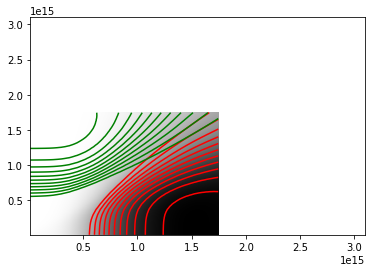

In [ ]:
# plot the interpolated Mb and Md functions

plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Mb(rhoc,rhocdm) as a color map (darker = larger Mb)
#plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Md(rhoc,rhocdm) as a color map (darker = larger Mb) -- but can't seem to show two colormaps at once

num_cs = 11
cs = plt.contour(x_grid,y_grid,outdat,list(np.linspace(1.,3.,num_cs)),colors='r') # plot the contours of constant Mb(rhoc,rhocdm)
cs_dm = plt.contour(x_grid,y_grid,outdat_dm,list(np.linspace(1.,3.,num_cs)),colors='g') # plot the contours of constant Md(rhoc,rhocdm)


In [ ]:
# extract the (rhoc,rhocdm) coordinates of the constant-fdm contours

contours = []
for i in range(num_cs+3):
  try: c = cs.allsegs[i][0] # if a contour was plotted, save it
  except: continue
  contours += [c] # list that stores all the extracted contours


In [ ]:
# downsample the contours to get a list of (rhoc,rhocdm) coordinates to use to generate a constant-fdm sequence of stars

num_stars = 100 # how many stars to aim for in the sequence
rhocs, rhocdms = [], []

for c in contours:
  
  skip = int(len(c[:,0])/num_stars)
  rhocs += [c[::skip,0]]
  rhocdms += [c[::skip,1]] # downselect to num_stars (rhoc,rhocdm) points


rhomin = 2.8e14 # because some central densities are too small to give physical neutron stars, throw out those below rhomin
rhomax = 12*rhomin # because some central densities are too large to give physical neutron stars, throw out those above rhomax
rhocs_out, rhocdms_out = [], []

for c,cdm in zip(rhocs,rhocdms):
  c_out, cdm_out = [], []

  for rhoc,rhocdm in zip(c,cdm):
    
    if (rhoc >= rhomin or rhocdm >= rhomin) and rhoc <= rhomax and rhocdm <=rhomax: # one of rhoc/rhocdm below rhomin is ok, to allow pure regular matter or pure dm star
      c_out += [rhoc]
      cdm_out += [rhocdm]
  rhocs_out += [c_out]
  rhocdms_out += [cdm_out]

In [ ]:
find_rhos(0)

('1661894184454549.5,1649339339339339.5,1634361952814901.2,1621501501501501.5,1607243315386800.0,1593663663663663.8,1580643308351082.2,1566063796385090.2,1553453453453453.5,1539868192904317.2,1525731165780900.8,1513243243243243.2,1499972758812907.5,1486247717260250.8,1473033033033033.0,1460660660660660.8,1447009757771211.2,1433004507692773.5,1420450450450450.5,1408078078078078.2,1394901396361845.5,1381189729652922.0,1367867867867868.0,1355495495495495.5,1343123123123123.2,1330159507603862.2,1316690136619247.5,1302947304667531.5,1290540540540540.5,1278168168168168.2,1265795795795795.8,1253423423423423.5,1240115709907921.8,1227431542400655.2,1214441332169284.8,1202274324865392.0,1189861465251771.8,1177186792024568.8,1164389907105775.8,1151939987165021.8,1140063032418331.0,1127925703660706.5,1115717524025666.2,1103468054268541.5,1091093052353709.5,1080000587517810.8,1067837837837837.9,1055465465465465.5,1043093093093093.1,1030720720720720.9,1019397932263579.1,1008145875048523.8,9966966966

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb0 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.66189418445e+15 g/cm^3
Done at central density 5.56168324023e+14 g/cm^3
Save to /content/macro_contour_mb0mpa1.csv


In [ ]:
find_rhos(1)

('1745225225225225.2,1730055844582047.0,1715655534740714.8,1701185586820273.8,1686456456456456.5,1670990990990991.0,1655579869484515.0,1642115124053349.5,1627687687687687.8,1612222222222222.2,1597056298838415.2,1583430135497567.8,1568918918918919.0,1553453453453453.5,1538766723759550.8,1525615615615615.8,1510150150150150.2,1495551686360664.8,1482312312312312.5,1466846846846847.0,1453453378051092.8,1439009009009009.0,1424571188469434.5,1411171171171171.2,1396683102838795.5,1383333333333333.5,1369401672310369.0,1355495495495495.5,1342347745959254.0,1327657657657657.8,1315285285285285.2,1300599390259106.8,1287447447447447.5,1274797517305922.5,1260372941342637.8,1247237237237237.2,1234775483472949.5,1220620503403631.0,1207027027027027.0,1194654654654654.8,1181425229186982.5,1167545526818587.0,1154444444444444.5,1142072072072072.2,1129699699699699.8,1116648695088229.8,1103399891892903.0,1089797398715755.9,1077117117117117.1,1064744744744744.8,1052372372372372.4,1040000000000000.0,1027406945

In [ ]:
len(find_rhos.newrhocs_list)

1872

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb1 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 6.03304154367e+14 g/cm^3
Save to /content/macro_contour_mb1mpa1.csv


In [ ]:
find_rhos(2)

('1745225225225225.0,1729870925306621.0,1717387387387387.5,1701921921921922.0,1689026828507839.5,1674084084084084.2,1661375971246556.0,1646246246246246.0,1632335089270227.5,1618408408408408.5,1604745013252063.0,1590570570570570.8,1577245332409209.5,1562732732732732.8,1550017342694931.5,1534894894894895.0,1522522522522522.5,1508408557792855.0,1494684684684684.5,1482312312312312.5,1468670571759899.0,1454474474474474.5,1442102102102102.2,1429625304879035.8,1415763289233896.0,1401939055006788.5,1389519519519519.5,1377147147147147.2,1364774774774774.8,1352005738100997.5,1338742321174083.8,1325441720258109.0,1313158389847995.5,1299819819819820.0,1287447447447447.5,1275075075075075.2,1262702702702702.8,1250330330330330.5,1237957957957958.0,1225585585585585.8,1213213213213213.2,1201181582042921.8,1188769711442940.0,1176156350036578.5,1164831998127399.0,1152577692892724.2,1141181515715663.8,1129699699699699.8,1117327327327327.4,1104954954954955.0,1092582582582582.6,1080210210210210.2,1068544350

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb2 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 6.47805370341e+14 g/cm^3
Save to /content/macro_contour_mb2mpa1.csv


In [ ]:
find_rhos(3)

('1745225225225225.2,1732852852852853.0,1720480480480480.5,1707932976583508.8,1694196323212071.0,1680270270270270.2,1667897897897898.0,1655525525525525.5,1643153153153153.2,1630001250223450.0,1616894770720200.0,1604106705965444.8,1591186272058712.5,1578198198198198.2,1565825825825826.0,1553453453453453.5,1541081081081081.0,1528708708708708.8,1516336336336336.5,1503963963963964.0,1491591591591591.5,1479219219219219.2,1467057901052562.0,1455228949796931.2,1443598016032470.5,1432202582467196.2,1420450450450450.5,1408078078078078.2,1395705705705705.8,1384186217628394.0,1372971145239373.0,1361681681681681.8,1349309309309309.5,1337706389820985.8,1327037723562506.0,1315285285285285.2,1302912912912913.0,1292357403771671.2,1281261261261261.2,1268925041100789.0,1258617276460112.0,1247237237237237.2,1235010538055899.8,1224742989342224.8,1213213213213213.2,1202557193885232.8,1191561561561561.8,1179539306300140.8,1169691476416893.8,1157537537537537.5,1146968311248631.5,1135885885885886.0,1125664649

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb3 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 6.92317916487e+14 g/cm^3
Save to /content/macro_contour_mb3mpa1.csv


In [ ]:
find_rhos(4)

('1745225225225225.2,1732852852852853.0,1718026264831942.5,1705015015015015.0,1691906255413750.5,1677177177177177.2,1664804804804805.0,1651700505470803.5,1636966966966966.8,1624594594594594.5,1612222222222222.2,1598372457646695.0,1584384384384384.5,1572012012012012.0,1559639639639639.8,1546871999724029.5,1533327190622533.8,1519823484154160.5,1507057057057057.0,1494684684684684.8,1482312312312312.5,1469939939939940.0,1457567567567567.8,1445195195195195.2,1432822822822823.0,1420450450450450.5,1408078078078078.2,1395705705705705.8,1383333333333333.5,1370960960960961.0,1359676448614393.2,1348205527273314.2,1336520514321136.2,1324564564564564.8,1312192192192192.2,1299819819819820.0,1287895066253273.8,1277271879399916.5,1265795795795795.8,1253423423423423.5,1241051051051051.0,1229601590552421.8,1219076086567556.5,1207027027027027.0,1195446139919598.8,1185375375375375.5,1173003003003003.0,1160744029590594.2,1150104374870266.0,1138978978978979.0,1127606834127954.8,1117327327327327.2,1105835228

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb4 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 7.37476094978e+14 g/cm^3
Save to /content/macro_contour_mb4mpa1.csv


In [ ]:
find_rhos(5)

('1745225225225225.2,1729759759759759.8,1717383144460768.0,1701921921921922.0,1688893185702214.8,1674084084084084.5,1661509230271515.8,1646246246246246.2,1633873873873874.0,1618630856813506.8,1606036036036036.0,1592023880570813.0,1578198198198198.2,1565825825825826.0,1551309288896792.8,1537987987987988.0,1525615615615615.8,1512481722685860.8,1498456841040303.8,1485405405405405.5,1473033033033033.0,1460660660660661.0,1447571208193459.5,1434325794623395.2,1421070784989257.5,1408078078078078.2,1395705705705705.8,1383333333333333.5,1370960960960961.0,1358588588588588.8,1346216216216216.0,1333843843843844.0,1321471471471471.5,1309099099099099.2,1296726726726727.0,1285114641482266.2,1273924122730643.2,1262320383555977.5,1250330330330330.5,1237957957957958.0,1225585585585585.8,1213213213213213.2,1201504314188077.8,1191068401118891.2,1179189189189189.0,1167422431193860.2,1156890894823474.8,1145165165165165.2,1132792792792793.0,1121898433004320.5,1111141141141141.2,1099519993721641.8,1089489489

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb5 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 7.86631691168e+14 g/cm^3
Save to /content/macro_contour_mb5mpa1.csv


In [ ]:
find_rhos(6)

('1745225225225225.2,1732852852852853.0,1719681335258738.8,1706416028624160.0,1694113700367213.0,1681813095455187.8,1669529588423085.5,1657370122388777.5,1645210656354470.2,1633147771602596.2,1621501501501501.5,1609129129129129.2,1596756756756756.8,1584384384384384.5,1572012012012012.0,1559639639639639.8,1548131734920778.0,1537317430752962.8,1525615615615615.5,1513243243243243.2,1500870870870871.0,1490103030239267.0,1479219219219219.2,1466846846846847.2,1455736354576038.8,1445195195195195.2,1432822822822823.0,1421886834733068.5,1411171171171171.2,1398798798798799.0,1388753621997617.5,1377147147147147.2,1366310924588668.0,1355495495495495.5,1345022930402339.5,1333843843843844.0,1323591752708027.8,1312192192192192.5,1301300885820689.0,1290540540540540.5,1280464536497415.5,1268888888888889.0,1259609609609609.8,1249731457408988.5,1238339101490584.5,1228678678678678.8,1218717797996137.5,1207271316426818.0,1197747747747747.8,1188225764419700.0,1177691735501659.0,1167186284342531.0,1157537537

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb6 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 8.4027305444e+14 g/cm^3
Save to /content/macro_contour_mb6mpa1.csv


In [ ]:
find_rhos(7)

('1745225225225225.2,1732852852852853.0,1720480480480480.5,1706474697842077.5,1692642642642642.8,1680270270270270.0,1667897897897898.0,1655525525525525.5,1643153153153153.2,1630287610268331.5,1618204524268764.5,1604935450201544.5,1591661659926124.0,1579277065244107.5,1566949955192897.8,1554459872705691.5,1543044832649764.2,1530430519072842.0,1518263798708079.2,1506601487693139.5,1494684684684684.5,1482312312312312.5,1469939939939940.0,1457567567567567.8,1446898820388967.8,1435915915915916.0,1423543543543543.5,1411171171171171.2,1400458160034263.8,1389519519519519.5,1377147147147147.2,1365858472025107.5,1355495495495495.5,1344121841740084.5,1333843843843844.0,1322593632707262.5,1312192192192192.2,1299819819819820.0,1290540540540540.5,1278345641130626.5,1268888888888889.0,1258135616741941.5,1247237237237237.5,1237957957957958.0,1226341271146417.0,1216306306306306.2,1207027027027027.0,1196968394989984.5,1185375375375375.5,1176096096096096.2,1166816816816817.0,1157224271517172.0,1146897271

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_mb7 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1.74522522523e+15 g/cm^3
Done at central density 9.00536367316e+14 g/cm^3
Save to /content/macro_contour_mb7mpa1.csv


In [ ]:
data_con_mb0 = np.genfromtxt('/content/macro_contour_mb0mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb1 = np.genfromtxt('/content/macro_contour_mb1mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb2 = np.genfromtxt('/content/macro_contour_mb2mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb3 = np.genfromtxt('/content/macro_contour_mb3mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb4 = np.genfromtxt('/content/macro_contour_mb4mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb5 = np.genfromtxt('/content/macro_contour_mb5mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb6 = np.genfromtxt('/content/macro_contour_mb6mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_mb7 = np.genfromtxt('/content/macro_contour_mb7mpa1.csv',delimiter=',',names=True,dtype=None)


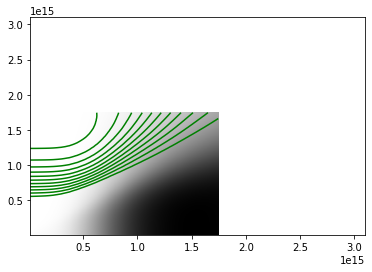

In [ ]:
# plot the interpolated Mb and Md functions

plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Mb(rhoc,rhocdm) as a color map (darker = larger Mb)
#plt.pcolormesh(x_grid,y_grid,outdat,cmap='gray_r') # show Md(rhoc,rhocdm) as a color map (darker = larger Mb) -- but can't seem to show two colormaps at once

num_cs = 11
# cs = plt.contour(x_grid,y_grid,outdat,list(np.linspace(1.,3.,num_cs)),colors='r') # plot the contours of constant Mb(rhoc,rhocdm)
cs_dm = plt.contour(x_grid,y_grid,outdat_dm,list(np.linspace(1.,3.,num_cs)),colors='g') # plot the contours of constant Md(rhoc,rhocdm)


In [ ]:
contours_dm = []
for i in range(num_cs+1):
  try: c = cs_dm.allsegs[i][0] # if a contour was plotted, save it
  except: continue
  contours_dm += [c] # list that stores all the extracted contours


In [ ]:
# downsample the contours to get a list of (rhoc,rhocdm) coordinates to use to generate a constant-fdm sequence of stars

num_stars = 100 # how many stars to aim for in the sequence
rhocs, rhocdms = [], []

for c in contours_dm:
  
  skip = int(len(c[:,0])/num_stars)
  rhocs += [c[::skip,0]]
  rhocdms += [c[::skip,1]] # downselect to num_stars (rhoc,rhocdm) points


rhomin = 2.8e14 # because some central densities are too small to give physical neutron stars, throw out those below rhomin
rhomax = 12*rhomin # because some central densities are too large to give physical neutron stars, throw out those above rhomax
rhocs_out, rhocdms_out = [], []

for c,cdm in zip(rhocs,rhocdms):
  c_out, cdm_out = [], []

  for rhoc,rhocdm in zip(c,cdm):
    
    if (rhoc >= rhomin or rhocdm >= rhomin) and rhoc <= rhomax and rhocdm <=rhomax: # one of rhoc/rhocdm below rhomin is ok, to allow pure regular matter or pure dm star
      c_out += [rhoc]
      cdm_out += [rhocdm]
  rhocs_out += [c_out]
  rhocdms_out += [cdm_out]

In [ ]:
find_rhos(0)

('10000000000000.0,37837837837837.84,62582582582582.586,90420420420420.42,115165165165165.17,143003003003003.0,167747747747747.75,192492492492492.5,217237237237237.25,238888888888888.9,262521555059330.22,285285285285285.3,305345011608098.0,325495495495495.5,347147147147147.2,365705705705705.75,384955613650927.9,402847694424369.8,422101019706822.0,441760223692285.75,458959208692170.0,477057057057057.1,495615615615615.6,514174174174174.2,530865985096659.2,548198198198198.25,566756756756756.8,583004893412494.1,600780780780780.9,618796976940566.1,634804804804804.9,650270270270270.2,668822944598192.5,684294294294294.4,701907641995618.5,718318318318318.4,733947661219758.1,750205243713445.4,767807807807807.9,783273273273273.4,800282613034602.8,817297297297297.2,833385555505631.5,850645973849502.0,866786786786786.9,882252252252252.2,897717717717717.8,915070510004924.2,931741741741741.8,947207207207207.2,962672672672672.8,978248797281370.5,995254088547509.4,1012162162162162.1,1027627627627627.8

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md0 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.74504497895e+15 g/cm^3
Save to /content/macro_contour_md0mpa1.csv


In [ ]:
find_rhos(1)

('10000000000000.0,37837837837837.84,62582582582582.59,90420420420420.44,115165165165165.17,143003003003003.0,167747747747747.75,192697325540698.22,217237237237237.25,241981981981982.0,264624276308798.88,288378378378378.4,310030030030030.06,330539468062082.8,350240240240240.25,371891891891891.94,390450450450450.5,409009009009009.0,427567567567567.56,446126126126126.1,464684684684684.7,483243243243243.25,501801801801801.8,520153291699109.8,535825825825825.9,554384384384384.44,569960746434751.1,588408408408408.5,603873873873873.9,622197017157515.5,637897897897897.9,653437767892449.6,669881214476127.4,686398885662061.6,702852852852852.9,718318318318318.4,733783783783783.9,750013879202606.0,766232007641989.2,782663750798323.2,798002920793510.5,813464157073887.0,829669669669669.8,845135135135135.0,860600600600600.6,876066066066066.0,891070782061358.2,906996996996997.0,922462462462462.5,937601536929155.4,952964355699887.4,966221621065166.8,981433065785552.4,996696696696696.8,1012162162162162

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md1 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.65029708163e+15 g/cm^3
Save to /content/macro_contour_md1mpa1.csv


In [ ]:
find_rhos(2)

('10000000000000.0,34744744744744.742,59489489489489.49,84234234234234.23,105885885885885.89,130630630630630.62,155375375375375.38,177027027027027.03,198678678678678.7,221956944521289.44,241981981981982.0,263633633633633.66,285285285285285.25,303843843843843.9,322402402402402.5,340960960960961.0,359976700517664.4,378078078078078.1,396636636636636.6,412102102102102.1,430660660660660.6,446126126126126.1,462355533196189.2,478836087536411.0,495180555096243.6,511081081081081.1,526546546546546.56,542012012012012.06,557400377446401.75,572245398409434.2,587090005808336.0,600780780780780.9,616246246246246.2,629804668790579.0,644084084084084.1,659141725632346.6,671921921921922.0,687387387387387.4,700545672500412.4,715225225225225.2,727597597597597.6,741369279430672.8,755435435435435.5,769161497896189.1,783273273273273.4,795645645645645.8,808466250429429.9,822869013637555.8,835855855855855.9,848890524241314.6,862798893212077.4,876066066066066.1,888438438438438.5,900810810810810.9,913554236016210.

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md2 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.51217051038e+15 g/cm^3
Save to /content/macro_contour_md2mpa1.csv


In [ ]:
find_rhos(3)

('10000000000000.0,31651651651651.65,53303303303303.305,73349482296326.81,93513513513513.52,115165165165165.17,136816816816816.83,155375375375375.38,177027027027027.03,195585585585585.6,217237237237237.25,235795795795795.8,254354354354354.38,272912912912912.94,291471471471471.5,306936936936936.94,325495495495495.5,340960960960961.0,359519519519519.56,374984984984985.0,390450450450450.5,405513560416928.9,419530772958932.25,433753753753753.75,449219219219219.25,462950299131817.56,477057057057057.1,491688019799219.06,504894894894894.94,520360360360360.3,532732732732732.75,545105105105105.1,558073459776047.6,571460217858725.8,585187502024219.6,597687687687687.8,610060060060060.0,622432432432432.5,634804804804804.9,647177177177177.2,659549549549549.6,671921921921922.0,683643960844322.8,694874851878599.5,706245038730089.1,718318318318318.4,730690690690690.8,741609438877781.5,752408646552871.1,764714714714714.8,776829153167966.6,786854350476260.9,798738738738738.8,809988190561183.5,8203903903

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md3 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.40191750885e+15 g/cm^3
Save to /content/macro_contour_md3mpa1.csv


In [ ]:
find_rhos(4)

('10000000000000.0,31651651651651.65,53303303303303.305,74954954954954.97,96606606606606.6,118258258258258.28,136816816816816.83,158468468468468.47,180120120120120.16,198678678678678.7,218703528494238.5,238888888888888.9,257447447447447.44,276006006006006.0,294564564564564.56,310030030030030.06,328588588588588.56,344054054054054.06,362532500728604.94,378078078078078.1,393229624665902.5,408340504507162.25,423387703272514.0,438267548214222.0,452312312312312.3,467714387973931.1,480150150150150.25,494660002696767.5,507987987987988.0,521737812906111.6,535825825825825.8,548198198198198.25,560570570570570.6,574808431103472.9,587872798833079.2,600617186295047.5,612591599269918.4,624566012244789.0,636138950268893.8,647217374310293.0,659549549549549.6,671921921921922.0,684294294294294.4,695050962650168.0,705945945945946.0,718318318318318.4,728490211243540.8,739969969969970.0,751671651712861.2,761621621621621.6,773993993993993.9,783776930852412.1,795645645645645.8,804924924924925.0,81635840692148

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md4 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.30291291291e+15 g/cm^3
Save to /content/macro_contour_md4mpa1.csv


In [ ]:
find_rhos(5)

('10000000000000.0,31651651651651.652,53303303303303.305,74954954954954.97,96606606606606.61,118258258258258.27,139909909909909.92,158468468468468.47,180120120120120.12,198678678678678.7,220330330330330.38,238888888888888.9,257447447447447.44,276006006006006.03,294564564564564.56,313123123123123.1,331681681681681.7,347147147147147.2,365705705705705.75,381171171171171.2,396406546308670.5,409928902959328.1,424474474474474.5,439939939939939.94,455405405405405.5,469026045593171.1,483243243243243.25,497740153846691.6,511081081081081.1,524787157115350.4,537591457885988.94,551291291291291.3,563663663663663.8,576036036036036.1,588408408408408.5,600780780780780.9,613153153153153.1,625525525525525.5,637897897897897.9,648662605157176.8,659549549549549.6,671921921921922.0,682484692644794.0,693573573573573.5,705945945945946.0,715225225225225.2,727310124205171.5,736876876876876.9,748669296933207.6,758528528528528.6,769952695218716.0,780180180180180.2,789967278970436.9,801081253013025.5,8111111111111

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md5 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.21875305137e+15 g/cm^3
Save to /content/macro_contour_md5mpa1.csv


In [ ]:
find_rhos(6)

('10000000000000.0,28558558558558.56,47117117117117.12,65675675675675.68,84234234234234.23,102792792792792.8,118258258258258.27,136816816816816.83,155375375375375.38,173933933933933.94,189399399399399.4,207957957957957.94,225417966111475.47,241981981981982.0,257447447447447.47,272912912912912.94,291471471471471.5,306936936936936.94,319690648637200.25,334774774774774.8,350240240240240.25,365705705705705.75,378776430734580.3,393543543543543.56,405915915915915.94,418288288288288.3,430660660660660.7,445062911071919.1,455554949535703.7,467777777777777.8,480150150150150.2,492522522522522.56,504894894894894.94,517199108165367.8,526546546546546.5,538918918918919.0,549638867654881.5,560570570570570.6,569990400730016.9,582222222222222.2,591694587014617.5,602646708561910.2,612923665119192.8,622432432432432.5,632136969773789.0,642121277829841.2,651289027634801.0,661419399117591.5,671405529240834.6,680774717485448.5,689346133089417.0,698820453958815.1,708208877525821.9,716780633077230.8,72514386757

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md6 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.13124851695e+15 g/cm^3
Save to /content/macro_contour_md6mpa1.csv


In [ ]:
find_rhos(7)

('10000000000000.0,28558558558558.56,44638440098142.42,62582582582582.586,81141141141141.14,99699699699699.7,118258258258258.27,136816816816816.83,155375375375375.38,170840840840840.84,189399399399399.4,207957957957957.97,223423423423423.44,241981981981982.0,257447447447447.47,272912912912912.94,291091710283563.4,306718273504213.44,320524424170262.7,334774774774774.8,350240240240240.25,365705705705705.75,378078078078078.1,391755624454318.75,405915915915915.94,418288288288288.3,431465655671859.1,446126126126126.1,457064065518478.5,467777777777777.8,480150150150150.1,492522522522522.5,504772061632584.75,515559167033787.25,526546546546546.56,538000426504563.25,548198198198198.25,559097001364493.75,569849849849849.9,579129129129129.1,589984876411027.0,600780780780780.9,610060060060060.1,619339339339339.4,628618618618618.6,637897897897897.9,647177177177177.2,656456456456456.5,665735735735735.8,675015015015015.0,684294294294294.4,692744946533161.8,701557521290313.8,709566322559890.4,71831831

In [ ]:
# calculate neutron star observables for a given equation of state

%%bash -s '$find_rhos.newrhocs_list' '$find_rhos.newrhocdms_list'
# this cell is a separate terminal instance

export PATH=$PATH:/opt/bin # the code doesn't need to be reinstalled in each terminal, but we do need to point to the install directory like this each time
export PYTHONPATH=$PYTHONPATH:/opt/lib/python2.7/site-packages

getnsprops mpa1.csv -p R,M,Rdm,Mdm,Mb,Md -d /content/ns-struc-dm/ -o /content/ -v -t macro_contour_md7 -r $1 -n 4 -R $2 # call the executable that computes the neutron star observables
# getnsprops [eos table] -p [observables to calculate] -m [mass range to calculate them for] 
#-d [directory where the eos table lives] -o [directory where the table of observables should be output]

Calculate properties of mpa1 stars
Start at central density 1e+13 g/cm^3
Done at central density 1.04248862054e+15 g/cm^3
Save to /content/macro_contour_md7mpa1.csv


In [ ]:
data_con_md0 = np.genfromtxt('/content/macro_contour_md0mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md1 = np.genfromtxt('/content/macro_contour_md1mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md2 = np.genfromtxt('/content/macro_contour_md2mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md3 = np.genfromtxt('/content/macro_contour_md3mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md4 = np.genfromtxt('/content/macro_contour_md4mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md5 = np.genfromtxt('/content/macro_contour_md5mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md6 = np.genfromtxt('/content/macro_contour_md6mpa1.csv',delimiter=',',names=True,dtype=None)
data_con_md7 = np.genfromtxt('/content/macro_contour_md7mpa1.csv',delimiter=',',names=True,dtype=None)


In [ ]:
def find_max(file):
  l = np.argmax((file['Mg']))
  R, M, rho_c, rho_cdm = file['R'][l], file['Mg'][l], file['rhoc'][l], file['rhocdm'][l]
  return R,M, rho_c, rho_cdm

In [ ]:
stable_md = []


In [ ]:
stable_md.append(find_max(data_con_md0))
stable_md.append(find_max(data_con_md1))
stable_md.append(find_max(data_con_md2))
stable_md.append(find_max(data_con_md3))
stable_md.append(find_max(data_con_md4))
stable_md.append(find_max(data_con_md5))
stable_md.append(find_max(data_con_md6))
stable_md.append(find_max(data_con_md7))


In [ ]:
stable_mb = []


In [ ]:
stable_mb.append(find_max(data_con_mb0))
stable_mb.append(find_max(data_con_mb2))
stable_mb.append(find_max(data_con_mb3))
stable_mb.append(find_max(data_con_mb4))
stable_mb.append(find_max(data_con_mb5))
stable_mb.append(find_max(data_con_mb6))
stable_mb.append(find_max(data_con_mb7))


In [ ]:
stable = stable_mb + stable_md


In [ ]:
stable_sort = np.sort(stable, axis = 0)

In [ ]:
xdata = np.array([x[0] for x in stable])
ydata = np.array([x[1] for x in stable])
x,y = zip(*sorted(zip(xdata,ydata),key=lambda xdata: xdata[0]))



# stable_line = np.polyfit(x,y,8)
x1,y1 = np.array(list(x)), np.array(list(y))
x2,y2 = x1.tolist(), y1.tolist()
xnew = np.linspace(0,20, 60, endpoint = True)
xnew2 =np.linspace(4.7,10.8, 60, endpoint = True)

In [ ]:
def func(x, a, b,c,d,e):
    return a*np.power(x,4) + b*np.power(x,3) + c*np.power(x,2) + d*x + e
popt, pcov = curve_fit(func, x1, y1)
func(x1, *popt)

def func_new(x, a,b,c,d,e):

  return np.piecewise(x, [x < min(x1), (x>= min(x1)) & (x< 1.1*max(x1)), x >= 1.1*max(x1)], [2.5,lambda x: func(x,a,b,c,d,e), 2.5])

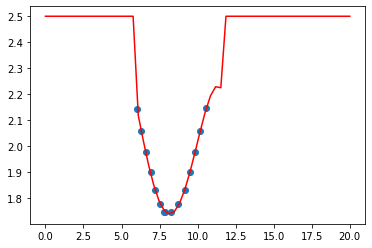

In [ ]:
plt.scatter([ x[0] for x in stable], [ x[1] for x in stable])
plt.plot(xnew, func_new(xnew, *popt), 'r-')

In [ ]:
def stable_crop(file,col,frac, a,b,c,d,e):
  boolean_array = file['Mg'] < func_new(file['R'],a,b,c,d,e)
  # print(boolean_array)
  boolean_new = []
  boolean_element = boolean_array[0]
  # print(boolean_array)
  i=0
  while boolean_element == True and i<len(boolean_array):
    boolean_element = boolean_array[i]
    boolean_new.append(boolean_element)
    i=i+1
  while i < len(boolean_array):
    boolean_new.append(False)
    i = i+1
  boolean_array = boolean_new
  # print(boolean_array)

  for i in range(len(boolean_array)):

    if boolean_array[i] == True:
      R,M = file['R'][i], file['Mg'][i]
      # print(R,M)
      plt.scatter(file['R'][i], file['Mg'][i],marker='.',s=3, c = col,label = '{}%'.format(frac) if i == 0 else "" )

    elif boolean_array[i] == False:
      R,M = file['R'][i], file['Mg'][i]
      # print(R, M, func(file['R'][i],a,b,c,d,e))
      

    # if file['M'] < func(file['R'], a,b,c,d,e):
    #   plt.scatter(file['R'], file['Mg'],marker='.',s=3, c = 'b' )
    # else:
    #   plt.scatter(file['R'], file['Mg'],marker='.',s=3, c = 'r' )
  

  return


In [ ]:
data_con = [data_con0,data_con1,data_con2, data_con3,data_con4, data_con5, data_con6, data_con7, data_con8,data_con9,data_con10]
data_frac = [1,10,20,30,40,50,60,70,80,90,99 ]
data_colours = ['b','g','r','c','m','y','indigo','pink','lime','brown','orange']

In [ ]:
# for i in data_con:
#   stable_crop(i,*popt)

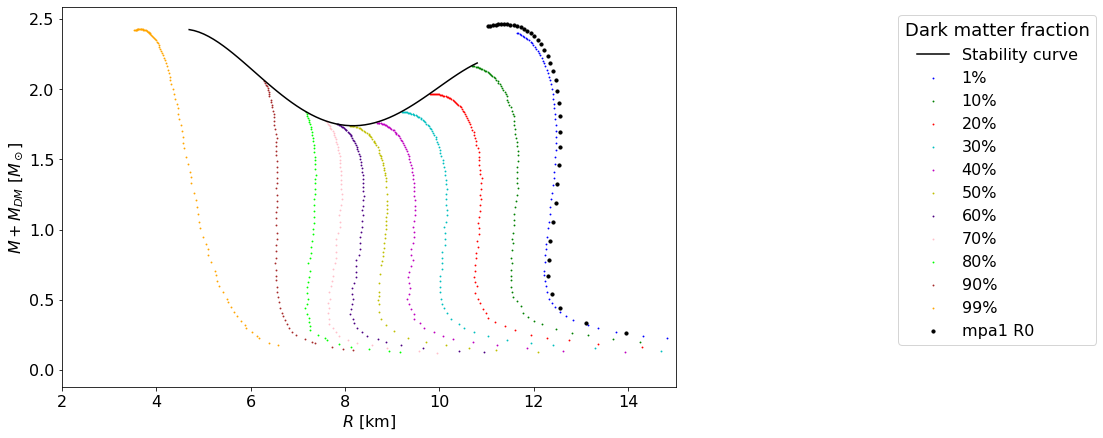

In [ ]:
plt.figure(figsize= (11,7))
for i,j,k in zip(data_con,data_frac,data_colours):
  stable_crop(i,k,j,*popt)
# stable_crop(data_con5,*popt)

plt.xlabel(r'$R$ [km]', size = 16) # add plot labels, etc.
plt.ylabel(r'$M+M_{DM}$ [$M_\odot$]', size = 16)
plt.plot(xnew2, func(xnew2, *popt), 'k-',label = 'Stability curve')
plt.scatter(mrl_data_mpa1['R'][0::48],(mrl_data_mpa1['Mg'])[0::48], label = '{} R0'.format('mpa1'), marker = 'o', color = 'k', s = 10)
# plt.scatter(dat['R'],dat['Mg'],marker='.',s=2,c='k')


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.35, 1), fontsize = 16, title='Dark matter fraction',title_fontsize=18 )
plt.xlim(2,15)
# plt.ylim(0,2.1)
plt.show()
